In [1]:
dataset_path = '/mnt/edisk/dataset/imagenet-mini/val'
qmodel_path = 'quantized.onnx'
model_path = 'origin.onnx'

In [2]:
from tqdm import tqdm
import pickle

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torch.ao.quantization.fake_quantize import FakeQuantize
from torch.ao.quantization.observer import HistogramObserver, PerChannelMinMaxObserver

from onnxutils.common import DatasetUtils
from onnxutils.quantization import symbolic_trace, ModuleQuantizer
from onnxutils.quantization.layer_observer import LayerObserver
from onnxutils.quantization.metric import compute_metrics

from imagenet_pipeline import ImageNetPipeline

# Prepare

In [3]:
class M(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, 3, 3, padding=1, bias=False)
        self.relu = nn.ReLU()

        self.conv0 = nn.Conv2d(3, 3, 3, padding=1, bias=False)
        self.relu0 = nn.ReLU()

        self.conv1 = nn.Conv2d(3, 3, 3, padding=1, bias=False)
        self.relu1 = nn.ReLU()
    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)

        x = self.conv0(x)
        x = self.relu0(x)

        x = self.conv1(x)
        x = self.relu1(x)
        return x

In [4]:
dataset = ImageNetPipeline.get_dataset(dataset_path)
torch_model = M()

torch_model.conv.reset_parameters()
torch_model.conv0.reset_parameters()
torch_model.conv1.reset_parameters()

# Analysis

# Quantization

In [5]:
graph_model = pickle.loads(pickle.dumps(torch_model))
graph_model = symbolic_trace(graph_model)

quantizer = ModuleQuantizer()
graph_model = quantizer.quantize(graph_model, [
    {
        'name': 'relu',
        'activation': FakeQuantize.with_args(observer=HistogramObserver),
    },
    {
        'module_name': 'conv0',
        'weight': FakeQuantize.with_args(observer=PerChannelMinMaxObserver),
    },
    {
        'module_name': 'relu0',
        'activation': FakeQuantize.with_args(observer=HistogramObserver),
    },
])

graph_model.print_readable()

class GraphModule(torch.nn.Module):
    def forward(self, x):
         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())
        conv = self.conv(x);  x = None
        
         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())
        relu = self.relu(conv);  conv = None
        
        # No stacktrace found for following nodes
        fq0 = self.fq0(relu);  relu = None
        
         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())
        conv0 = self.conv0(fq0);  fq0 = None
        
         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(Captur

"class GraphModule(torch.nn.Module):\n    def forward(self, x):\n         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())\n        conv = self.conv(x);  x = None\n        \n         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())\n        relu = self.relu(conv);  conv = None\n        \n        # No stacktrace found for following nodes\n        fq0 = self.fq0(relu);  relu = None\n        \n         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())\n        conv0 = self.conv0(fq0);  fq0 = None\n        \n         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace =

100%|████████████████████████████████████████████████| 100/100 [01:12<00:00,  1.38it/s]


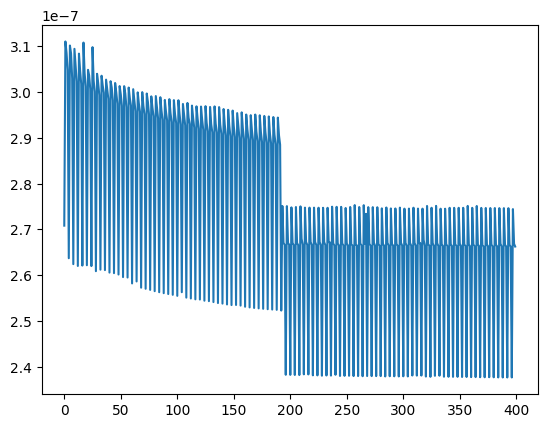

In [6]:
dataloader = DataLoader(
    DatasetUtils.take_front(
        DatasetUtils.transform(
            dataset,
            lambda items: (items[0].to('cuda'),)
        ),
        256
    ),
    batch_size=64
)
torch_model.eval().to('cuda')
graph_model.train().to('cuda')

loss_vals = []
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(graph_model.parameters(), lr=1e-2)

for _ in tqdm(range(100)):
    for data in dataloader:
        gt = torch_model(*data)
        pred = graph_model(*data)

        loss = loss_fn(pred, gt)
        loss_vals.append(loss.detach().cpu().item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

plt.plot(loss_vals)

# Preview

In [7]:
dataloader = DataLoader(
    DatasetUtils.drop_front(
        DatasetUtils.transform(
            dataset,
            lambda items: (items[0].to('cuda'),)
        ),
        256
    ),
    batch_size=16
)
torch_model.eval().to('cuda')
graph_model.eval().to('cuda')

for data in dataloader:
    gt = torch_model(*data)
    pred = graph_model(*data)

    print(compute_metrics(gt, pred))
    break

{'cosine': tensor([0.9999, 0.9999, 1.0000, 1.0000, 0.9999, 1.0000, 0.9999, 0.9999, 1.0000,
        0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 1.0000],
       device='cuda:0', grad_fn=<SumBackward1>), 'snr': tensor([13415.0518,  3894.8372,  4549.0244,  3760.0725,   601.9656,  4250.4390,
         8437.6562,  5590.9229,  4754.9443,  5006.2725,  2813.2605,  6986.8975,
         5018.7051,  4104.3696,  1491.5604,  7911.5566], device='cuda:0',
       grad_fn=<SumBackward1>), 'mse': tensor([3.8685e-07, 2.4038e-07, 1.6227e-07, 2.7490e-07, 2.0301e-08, 2.7304e-07,
        9.0683e-08, 2.0362e-07, 3.0798e-07, 1.2993e-07, 1.2795e-07, 2.4153e-07,
        1.8926e-07, 3.3397e-07, 5.6724e-08, 4.3277e-07], device='cuda:0',
       grad_fn=<MeanBackward1>)}


# Export

In [8]:
finalized_model = quantizer.finalize(graph_model).to('cuda')
torch.onnx.export(
    finalized_model,
    tuple(next(iter(dataloader))),
    qmodel_path,
    input_names=['x'],
    output_names=['y'],
)
torch.onnx.export(
    torch_model,
    tuple(next(iter(dataloader))),
    model_path,
    input_names=['x'],
    output_names=['y'],
)